In [1]:
import matplotlib.pyplot as plt
import astricaltools as at
import numpy as np
import pandas as pd
import scipy.stats as sc
from astropy import stats
import astropy.units as u
from astropy.io import fits
from astropy.table import vstack, Table
from astropy.time import Time
from astropy.timeseries import TimeSeries
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, Angle

In [2]:
file_numbers = range(1, 10)  # da 001 a 009
base_path = "astri_{:03d}_43_009_00002_R_201023_004_0201_SEB.lv0"  # pattern del nome file

dfs = []  # lista per accumulare i DataFrame
print("\n")
for i in file_numbers:
    filename = base_path.format(i)
    print(f"{filename}")

    with at.io.fits.AstriFits(filename) as hdul:
        data = hdul[1].data

        # Conversione dei campi
        time_ns = data["TIME_NS"].byteswap().newbyteorder().astype(np.int64)
        time_s  = data["TIME_S"].byteswap().newbyteorder().astype(np.int64)
        event   = data["EVTNUM"].byteswap().newbyteorder().astype(np.int64)
        mcrun   = data["MCRUNNUM"].byteswap().newbyteorder().astype(np.int64)
        time_abs = time_s * 10**9 + time_ns  # tempo assoluto in ns
        hg, lg, ttp = hdul.get_data('events', ['hi', 'lo', 'ttp'])
        time_abs = time_s * 10**9 + time_ns  # tempo assoluto in ns
            #creo il dataframe
        df = pd.DataFrame({
                "TIME_NS": time_ns,
                "TIME_S": time_s,
                "TIME_ABS": time_abs,
                "EVENT": event,
                "MCRUN": mcrun,
                "TEL_ID": i,
                "HG": list(hg),             
                "LG": list(lg),
                "TTP": list(ttp)
            })

        dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)
df_all_sorted= df_all.sort_values(by="TIME_ABS").reset_index(drop=True)
print(df_all.head())
print(df_all_sorted.head())





astri_001_43_009_00002_R_201023_004_0201_SEB.lv0
astri_002_43_009_00002_R_201023_004_0201_SEB.lv0
astri_003_43_009_00002_R_201023_004_0201_SEB.lv0
astri_004_43_009_00002_R_201023_004_0201_SEB.lv0
astri_005_43_009_00002_R_201023_004_0201_SEB.lv0
astri_006_43_009_00002_R_201023_004_0201_SEB.lv0
astri_007_43_009_00002_R_201023_004_0201_SEB.lv0
astri_008_43_009_00002_R_201023_004_0201_SEB.lv0
astri_009_43_009_00002_R_201023_004_0201_SEB.lv0
    TIME_NS  TIME_S  TIME_ABS  EVENT   MCRUN  TEL_ID  \
0  15104575       0  15104575   2217  263211       1   
1  25307129       0  25307129   7009  263211       1   
2  28859186       0  28859186   2217  263212       1   
3  32680807       0  32680807   4213  263212       1   
4  35023796       0  35023796    417  263213       1   

                                                  HG  \
0  [[2158, 2264, 2118, 2251, 2150, 2144, 2247, 22...   
1  [[2251, 2145, 2137, 2122, 2236, 2138, 2146, 22...   
2  [[2107, 2316, 2213, 2026, 2181, 2110, 2212, 21...

In [13]:
df_target= df_all_sorted[
    ((df_all_sorted['EVENT'] == 7009 ) | (df_all_sorted['EVENT'] == 7008  )) &
    ((df_all_sorted['MCRUN'] == 263458) | (df_all_sorted['MCRUN'] == 263458) )
]
#print(df_target[["TIME_NS", "TIME_S","TIME_ABS"]])
print(f"delta t massimo = {df_target['TIME_ABS'].max() - df_target['TIME_ABS'].min()} ns")
print(f"delta t massimo(log) = {np.log10(2401)}")
print(f"delta t minimo = {2473242337-2473242747} ns")
print(f"delta t minimo(log) = {np.log10(410)}")
#df_target.head

delta t massimo = 2401 ns
delta t massimo(log) = 3.3803921600570273
delta t minimo = -410 ns
delta t minimo(log) = 2.6127838567197355


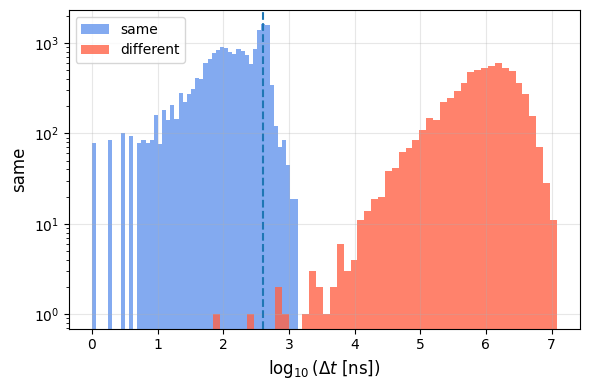

In [19]:
delta_t=np.diff(df_all_sorted["TIME_ABS"])
delta_ts = delta_t[delta_t > 0] #uso maschere e cambio

#ordino eventi con il for e suddivisione same e different
df_all_sorted=df_all.sort_values(["MCRUN","EVENT","TIME_ABS"]).reset_index(drop=True)
delta_t_same = []
delta_t_diff = []

for i in range(1, len(df_all_sorted)):
    if ((df_all_sorted.loc[i, "MCRUN"]==df_all_sorted.loc[i-1, "MCRUN"])&
        (df_all_sorted.loc[i, "EVENT"] ==df_all_sorted.loc[i-1, "EVENT"])):
        delta_t_same.append(df_all_sorted.loc[i, "TIME_ABS"]-
                            df_all_sorted.loc[i-1, "TIME_ABS"])
    else:
        delta_t_diff.append(df_all_sorted.loc[i, "TIME_ABS"]-
                            df_all_sorted.loc[i-1, "TIME_ABS"])
delta_t_same = np.array(delta_t_same)
delta_t_diff = np.array(delta_t_diff)
delta_t_same_safe = np.where(delta_t_same > 0, delta_t_same, 1)
delta_t_diff_safe = np.where(delta_t_diff > 0, delta_t_diff, 1)
#suddivido tra stesso evento e evento separato sostituendo i deltat con 1
plt.figure(figsize=(6, 4))
plt.hist(np.log10(delta_t_same[delta_t_same > 0]), bins=50, color='cornflowerblue',
         alpha=0.8,label='same')
plt.hist(np.log10(delta_t_diff[delta_t_diff > 0]), bins=50, color='tomato',
         alpha=0.8,label='different')
plt.yscale('log')
plt.xlabel(r'$\log_{10}(\Delta t\ \mathrm{[ns]})$', fontsize=12)
plt.ylabel('same', fontsize=12)
#plt.xlim(left=0)
plt.tight_layout()
plt.grid(alpha=0.3)
plt.legend()
plt.axvline(2.61, linestyle='--')
plt.show()


In [ ]:
df_target=df_target[df_target[]]